---
# Optional: 

- Ellipses and phase space distribution

---

#### Setup of your Python kernel
Let's load our standard library functions, and setup matplotlib for nice inline plots

In [4]:
# Import custom tracking functions and useful libraries
from tracking_library import *

# Set up plotting
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

### Exercise 24 (optional)

Consider the usual FODO cell ($f=2.5$, $L=2$), and again a single particle with non-zero initial coordinates (e.g. $x_0 =2.1$; $x' = 2.3$).

Plot again the particle coordinates in phase space for 100 passages along this FODO cell. Then, reverse the polarity of both quadrupoles and repeat. How does the result differ? Why?

#### SOLUTION

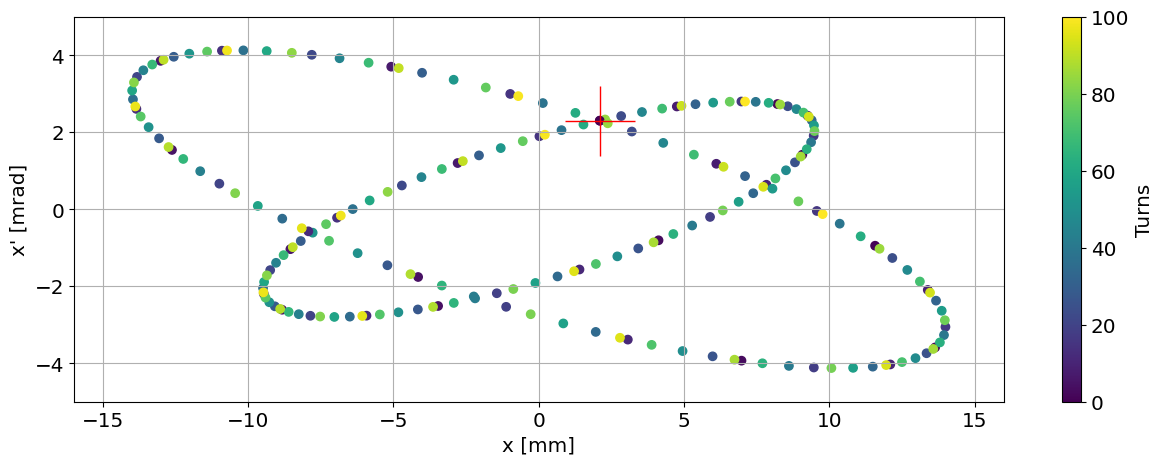

In [16]:
# let's put everything in a simple function
def plotIt(x, xp, f, L):
    particle = [[x],[xp]]
    fodo_cell = 5*D(L/10) + Q(f) + 10*D(L/10) + Q(-f) + 5*D(L/10)
    OTM = getEquivalentElement(fodo_cell)
    transported_particles = transportParticles(particle,100*OTM)
    plt.scatter(transported_particles['x'], transported_particles['xp'], c = transported_particles['s']/(L*2))

# a single case
x = 2.1
xp = 2.3
f = 2.5
L = 2
# normal polarity
plotIt(x, xp,  f, L)
# inversed polarity
plotIt(x, xp, -f, L)
# indicate starting point
plt.plot(x, xp,'+r', ms=50)

# add some labels
cb=plt.colorbar()
cb.set_label('Turns')
plt.xlabel('x [mm]')
plt.ylabel("x' [mrad]")
plt.xlim(-16,16)
plt.ylim(-5,5)
plt.grid(True)

---

## Ellipses ans Single Particle Emittance

It turns out that our particle turn-after-turn stays on an ellipses: 

\begin{equation}
\epsilon = \gamma x^2 + 2 \alpha x x' + \beta x{'\,}^2
\end{equation}

where $(\alpha, \beta, \gamma)$ are the periodic Twiss parameter! and $\epsilon$, in this case, is the **single particle emittance**.

Without entering in the implementation details, two useful functions are defined in our library toolbox: 
- one that can give us the single particle emittance: `particle_emittance(x, xp, beta, alpha)`
- one to give us the coordinate in phase space for an ellipse with the given Twiss and emittance: `ellipse_points(emittance, beta, alpha, n_points = 100)`

In [2]:
from tracking_library import particle_emittance
from tracking_library import ellipse_points

help(particle_emittance)
help(ellipse_points)

Help on function particle_emittance in module tracking_library:

particle_emittance(x, xp, beta, alpha)
    Returns the single particle emittance for a given 
    x, xp particle coordinates and assumed beta and alpha parameters

Help on function ellipse_points in module tracking_library:

ellipse_points(emittance, beta, alpha, n_points=100)
    Returns the x,x' coordinates of an ellipse in phase space for 
    the given Twiss parameters (beta, gamma, emittance)



### Exercise 25

Consider the usual FODO cell, repeated 100 times.
Plot the trajectory, in phase space, of a particle with $x=2$ mm and $x'=1.5$ cell after cell.

Using the functions you have now available, compute the expected periodic solution of our cell, and use this information to:

- compute the single particle emittance
- produce the coordinates in phase space of an ellipse with such an emittance

1. Plot both the tracked particle coordinates and the ellipse in phase space: what do you observe?
2. What happens if you change the sign of the quadrupoles, but don't change the initial particle coordinates? Is there a difference in single particle emittance? Why?

**Optional:** would you be able to predict the exact tracked particle coordinates only from the single cell?

**Hint:** for this last question, one needs to look carefully at the functions implementation details...


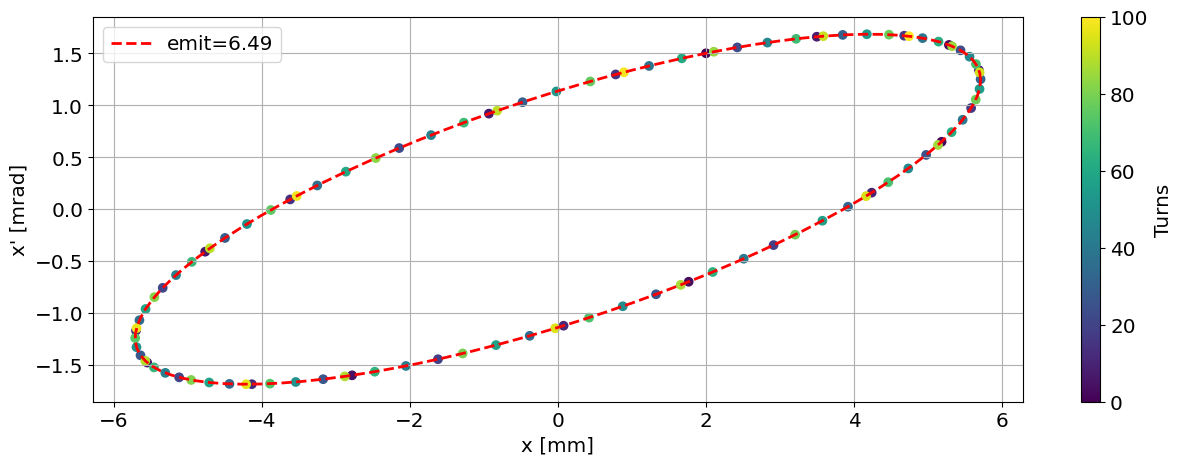

In [23]:
# define our usual FODO cell
f = 2.5
L = 2
fodo_lattice = 5*D(L/10) + Q(f) + 10*D(L/10) + Q(-f) + 5*D(L/10)

# compute the periodic solution
tune, beta, alpha, gamma = twiss(fodo_lattice)

# generate a particle
x = 2
xp = 1.5
particle = [[x],[xp]]

# compute the associate single-particle emittance of this particle
single_part_emit = particle_emittance(x, xp, beta, alpha)
# get coordinate of an ellipse in phase space with the given parameters
ellipse_coordinates = ellipse_points(single_part_emit, beta, alpha)

# track the particle over 100 cells
OTM = getEquivalentElement(fodo_lattice)
transported_particles = transportParticles(particle,100*OTM)

# plot tracked particles as well as ellipse
plt.plot(ellipse_coordinates[0,:], ellipse_coordinates[1,:],'r--', lw=2, label=f'emit={single_part_emit:.2f}')
plt.scatter(transported_particles['x'], transported_particles['xp'], c = transported_particles['s']/(L*2))
cb=plt.colorbar()
cb.set_label('Turns')
plt.xlabel('x [mm]')
plt.ylabel("x' [mrad]")
plt.grid(True)
plt.legend()
    
